#  Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [37]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm
import os

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
positiveNegative.shape

(525814,)

In [4]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

#  Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

# Time Based Splitting 

In [6]:
#Sorting data according to Time Stamp in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [10]:
minor=final[final.Score=='negative']
major=final[final.Score=='positive']
minor_sample=resample(minor,replace=True,n_samples=307061,random_state=123)
final=pd.concat([major,minor_sample])

In [11]:
label=np.array(final['Score'])

##   Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

7
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [13]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'will', 'them', "shouldn't", 'off', 'she', "hasn't", 'wouldn', "haven't", 'be', 'nor', "it's", 'in', 'on', "you're", 'here', 'her', 'my', 'doing', 've', 'isn', 'who', 'mustn', 'do', 'his', 'does', "hadn't", 'now', 'below', 'all', 'each', 'hasn', "weren't", 'as', 'our', 'until', 'why', "mightn't", 'yourselves', 'shan', 'was', 'are', 'hadn', 'been', 'had', "she's", 'he', 'himself', "wouldn't", "that'll", 'herself', 'won', 'it', 'your', "you've", 'am', 'don', 'mightn', 'being', 'any', 'for', 'this', 'its', 'of', 'same', 'out', "doesn't", 'while', 'were', 'ma', 'so', "wasn't", 'they', 'both', 'after', "isn't", "didn't", 'own', "should've", 'myself', 'once', 'y', 'further', 't', 'ourselves', 'aren', 'd', 'm', 'those', 'didn', 'at', 'against', 'yours', 're', "couldn't", "don't", "you'll", 'that', 'just', 'hers', 'but', 'haven', 'into', 'can', 'couldn', 'theirs', "shan't", 's', 'than', 'the', 'if', 'up', 'when', 'weren', 'what', 'with', 'has', 'to', 'under', 'have', 'between', 'him', 'did', 

In [14]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [15]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [16]:
print(final.head(3))#below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

            Id   ProductId         UserId         ProfileName  \
138706  150524  0006641040  ACITT7DI6IDDL     shari zychinski   
138683  150501  0006641040  AJ46FKXOVC7NR  Nicholas A Mesiano   
417839  451856  B00004CXX9  AIUWLEQ1ADEG5    Elizabeth Medina   

        HelpfulnessNumerator  HelpfulnessDenominator     Score       Time  \
138706                     0                       0  positive  939340800   
138683                     2                       2  positive  940809600   
417839                     0                       0  positive  944092800   

                                                  Summary  \
138706                          EVERY book is educational   
138683  This whole series is great way to spend time w...   
417839                               Entertainingl Funny!   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138683  I can remember seeing the show when it aired o...   
41

In [17]:
label[0]

'positive'

In [18]:
i=0
j=label.size
labels=[]
for i in range(0,j):
    if label[i]=='positive':
        labels.append(1)
    else:
        labels.append(0)
    


In [19]:
finals=final[0:]
print(labels[0])

1


In [20]:
from sklearn import cross_validation
final_Train, final_Test, label_Tr, label_Te = cross_validation.train_test_split(finals,labels, test_size=0.3, random_state=0)

In [21]:
from sklearn import cross_validation
final_Train, final_Test, label_Train, label_Test = cross_validation.train_test_split(finals,labels, test_size=0.3, random_state=0)

In [22]:
print(label_Train[0])

1


In [23]:
print(label_Test[0:10])

[0, 1, 1, 0, 1, 1, 1, 1, 0, 1]


#  Bag of Words (BoW)

In [24]:
count_vec = CountVectorizer()
final_Tr = count_vec.fit_transform(final_Train['CleanedText'].values)
final_Te = count_vec.transform(final_Test['CleanedText'].values) 

In [25]:
features = count_vec.get_feature_names()
clnames=['positive','negative']

In [26]:
final_Te.shape

(184237, 62092)

In [27]:
type(final_Te)

scipy.sparse.csr.csr_matrix

In [28]:
final_Tr.shape

(429885, 62092)

# k fold cross Validation

In [30]:

myList = [10,15,20,25,30]
maxdepth=[5,10,15,20,25]

# empty list that will hold cv scores
#cv_scores = []
optimal_c=0
m=0
maxd=0
mean=0
# perform 10-fold cross validation
for k in myList:
    for l in maxdepth:
        DT = RandomForestClassifier(n_estimators=k,max_depth=l,n_jobs=-1)
        scores = cross_val_score(DT, final_Tr, label_Train, cv=5, scoring='accuracy')
        m=scores.mean()
        if(mean<m):
            mean=scores.mean()
            optimal_c=k
            maxd=l
        #cv_scores.append(scores.mean())
        print("\n cv score for no of estimators ={} and max_depth = {} is {}".format(k,l,m))
        

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

#optimal_c = myList[MSE.index(min(MSE))]
print('\nThe optimal no of estimators are {} and Max depth is{}.' .format(optimal_c,maxd))


 cv score for no of estimators =10 and max_depth = 5 is 0.6596834037009899

 cv score for no of estimators =10 and max_depth = 10 is 0.7060772066948137

 cv score for no of estimators =10 and max_depth = 15 is 0.7548041918187421

 cv score for no of estimators =10 and max_depth = 20 is 0.7750189004035962

 cv score for no of estimators =10 and max_depth = 25 is 0.7943194110052689

 cv score for no of estimators =15 and max_depth = 5 is 0.6945927399188155

 cv score for no of estimators =15 and max_depth = 10 is 0.742914965630343

 cv score for no of estimators =15 and max_depth = 15 is 0.7776428579736441

 cv score for no of estimators =15 and max_depth = 20 is 0.7997906416832408

 cv score for no of estimators =15 and max_depth = 25 is 0.8219500564104354

 cv score for no of estimators =20 and max_depth = 5 is 0.7097712178838526

 cv score for no of estimators =20 and max_depth = 10 is 0.7678169743070822

 cv score for no of estimators =20 and max_depth = 15 is 0.78668015864708

 cv 

In [31]:
print(MSE)

[0.343878013887435, 0.284006187701362, 0.2499459157681705, 0.22632099282366214, 0.2077067122602556, 0.31519359828791427, 0.26078602416925456, 0.22642799818556125, 0.19494748595554634, 0.17841748374565292, 0.28162415529734686, 0.23855914953999324, 0.1981274061667655, 0.18156251090407916, 0.17152261651371892, 0.27415936820312403, 0.22350861276853118, 0.19328657664259052, 0.17845470300196564, 0.1613454761157055, 0.25859474045384245, 0.20583411842702115, 0.18861090756830312, 0.17483047791851314, 0.15688381776521632]


In [33]:
DT = RandomForestClassifier(n_estimators=optimal_c,max_depth=maxd,n_jobs=-1)
DT.fit(final_Tr,label_Train)
pred= DT.predict(final_Te)
acc = accuracy_score(label_Test, pred, normalize=True) * float(100)
print("\n****Test accuracy for no estimators ={} and max_depth is {} is {}".format(optimal_c,maxd,acc))


****Test accuracy for no estimators =30 and max_depth is 25 is 85.20655460086736


# GridSearchCv

In [36]:
tuned_parameters = [{'n_estimators': [5,10,15,20,25,30],'max_depth':[5,10,15,20,25]}]
model = GridSearchCV(RandomForestClassifier(),tuned_parameters, scoring = 'f1', cv=5,n_jobs=-1)
model.fit(final_Tr,label_Train)

print(model.best_estimator_)
print(model.score(final_Te, label_Test))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8519944749068687


# RandomizedSearchCV

In [37]:
tuned_parameters = {'n_estimators': [5,10,15,20,25,26,27,28,29,30,31,32,33,34,35],'max_depth':[5,10,15,20,25,30,35,40,45,50,55,60]}
model = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1), tuned_parameters, scoring = 'f1', cv=5)
model.fit(final_Tr,label_Train)

print(model.best_estimator_)
print(model.score(final_Te, label_Test))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=55, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9173282057341741


In [38]:
cm=confusion_matrix(label_Test,pred)

In [39]:
tn, fp, fn, tp = confusion_matrix(label_Test,pred).ravel()
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 76220 
 false positives are 15921 
 false negatives are 11334
 true positives are 80762 
 


       0      1
0  76220  15921
1  11334  80762


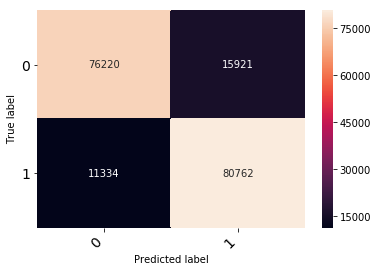

In [40]:
index_names=['0','1']
class_names=['0','1']
df_cm = pd.DataFrame(cm, index=index_names, columns=class_names)
print(df_cm)
hp =sns.heatmap(df_cm, annot=True, fmt="d")
hp.yaxis.set_ticklabels(hp.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
hp.xaxis.set_ticklabels(hp.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [41]:
print("f1-score    ",f1_score(label_Test,pred))
print("precision_score   ",precision_score(label_Test,pred))
#recall score
print("recall_score    ",recall_score(label_Test,pred))
#accuracy score
print("accuracy    ",accuracy_score(label_Test,pred))

f1-score     0.85562483115177
precision_score    0.8353278239194067
recall_score     0.87693276580959
accuracy     0.8520655460086736


# TF-IDF

In [42]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_Tr = tf_idf_vect.fit_transform(final_Train['CleanedText'].values)
final_Te = tf_idf_vect.transform(final_Test['CleanedText'].values)

In [43]:
features = tf_idf_vect.get_feature_names()
len(features)


62092

# k fold cross validation

In [44]:

myList = [10,15,20,25,30]
maxdepth=[5,10,15,20,25]

# empty list that will hold cv scores
#cv_scores = []
optimal_c=0
m=0
maxd=0
mean=0
# perform 10-fold cross validation
for k in myList:
    for l in maxdepth:
        DT = RandomForestClassifier(n_estimators=k,max_depth=l,n_jobs=-1)
        scores = cross_val_score(DT, final_Tr, label_Train, cv=5, scoring='accuracy')
        m=scores.mean()
        if(mean<m):
            mean=scores.mean()
            optimal_c=k
            maxd=l
        #cv_scores.append(scores.mean())
        print("\n cv score for no of estimators ={} and max_depth = {} is {}".format(k,l,m))
        

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

#optimal_c = myList[MSE.index(min(MSE))]
print('\nThe optimal no of estimators are {} and Max depth is{}.' .format(optimal_c,maxd))


 cv score for no of estimators =10 and max_depth = 5 is 0.6741965874594368

 cv score for no of estimators =10 and max_depth = 10 is 0.714063063377415

 cv score for no of estimators =10 and max_depth = 15 is 0.7552182560452214

 cv score for no of estimators =10 and max_depth = 20 is 0.7728276166881841

 cv score for no of estimators =10 and max_depth = 25 is 0.785491468648592

 cv score for no of estimators =15 and max_depth = 5 is 0.687176803098503

 cv score for no of estimators =15 and max_depth = 10 is 0.7348337346034405

 cv score for no of estimators =15 and max_depth = 15 is 0.7765611733370552

 cv score for no of estimators =15 and max_depth = 20 is 0.8011282087069798

 cv score for no of estimators =15 and max_depth = 25 is 0.8216453237493748

 cv score for no of estimators =20 and max_depth = 5 is 0.7152564057829418

 cv score for no of estimators =20 and max_depth = 10 is 0.7642090326482663

 cv score for no of estimators =20 and max_depth = 15 is 0.7869337148307106

 cv 

In [45]:
DT = RandomForestClassifier(n_estimators=optimal_c,max_depth=maxd,n_jobs=-1)
DT.fit(final_Tr,label_Train)
pred= DT.predict(final_Te)
acc = accuracy_score(label_Test, pred, normalize=True) * float(100)
print("\n****Test accuracy for no estimators ={} and max_depth is {} is {}".format(optimal_c,maxd,acc))


****Test accuracy for no estimators =30 and max_depth is 25 is 84.22955215293345


# GridSearchCv

In [46]:
tuned_parameters = [{'n_estimators': [5,10,15,20,25,30],'max_depth':[5,10,15,20,25]}]
model = GridSearchCV(RandomForestClassifier(), tuned_parameters, scoring = 'f1', cv=5,n_jobs=-1)
model.fit(final_Tr,label_Train)

print(model.best_estimator_)
print(model.score(final_Te, label_Test))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8602918281671086


# RandomizedSearchCV

In [47]:
tuned_parameters = {'n_estimators': [5,10,15,20,25,26,27,28,29,30,31,32,33,34,35],'max_depth':[5,10,15,20,25,30,35,40,45,50,55,60]}
model = RandomizedSearchCV(RandomForestClassifier(n_jobs= -1), tuned_parameters, scoring = 'f1', cv=5)
model.fit(final_Tr,label_Train)

print(model.best_estimator_)
print(model.score(final_Te, label_Test))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9301925983926571


In [48]:
cm=confusion_matrix(label_Test,pred)
tn, fp, fn, tp = confusion_matrix(label_Test,pred).ravel()
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 74896 
 false positives are 17245 
 false negatives are 11810
 true positives are 80286 
 


       0      1
0  74896  17245
1  11810  80286


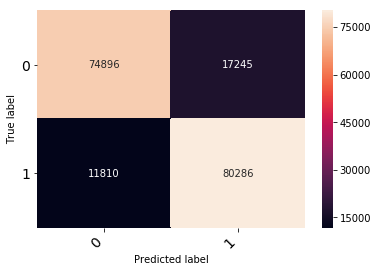

In [49]:
index_names=['0','1']
class_names=['0','1']
df_cm = pd.DataFrame(cm, index=index_names, columns=class_names)
print(df_cm)
hp =sns.heatmap(df_cm, annot=True, fmt="d")
hp.yaxis.set_ticklabels(hp.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
hp.xaxis.set_ticklabels(hp.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [50]:
print("f1-score    ",f1_score(label_Test,pred))
print("precision_score   ",precision_score(label_Test,pred))
#recall score
print("recall_score    ",recall_score(label_Test,pred))
#accuracy score
print("accuracy    ",accuracy_score(label_Test,pred))

f1-score     0.8467781486813587
precision_score    0.823184423414094
recall_score     0.8717642460041696
accuracy     0.8422955215293345


#  Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final_Train['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

C:\Users\Dileep\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [29]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent1=[]
for sent in final_Test['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent1.append(filtered_sentence)
    

In [30]:
from gensim.models import Word2Vec
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [31]:
w2v_model1=Word2Vec(list_of_sent1,min_count=5,size=50, workers=4)

In [32]:
w2v_words = list(w2v_model.wv.vocab)

In [33]:
print(final_Train['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

My dog loves these and they are good for her too. She comes running when she hears me opening the container. The container makes it very nice to keep them on the counter top.
*****************************************************************
['dog', 'love', 'good', 'come', 'run', 'hear', 'open', 'contain', 'contain', 'make', 'nice', 'keep', 'counter', 'top']


In [34]:
print(final_Test['Text'].values[0])
print("*****************************************************************")
print(list_of_sent1[0])

As far as taste goes, these are great... but of course they are, they are loaded with sugar!!!!! Organic dried cane syrup sounds like it's okay, but it's just a fancy way of wording the fact that these are made with SUGAR. There are other brands out there (would name them, but do not want the credibility of my review to plummet in case someone thinks I'm "working" for one of these other brands) that sweeten their puffs with fruit juice, a MUCH healthier option over these Plum brand puffs made with sugar. I am disappointed that I bought FOUR of these... save YOUR money and look elsewhere for a healthier option for your child :)
*****************************************************************
['far', 'tast', 'goe', 'great', 'cours', 'load', 'sugar', 'organ', 'dri', 'cane', 'syrup', 'sound', 'like', 'okay', 'fanci', 'way', 'word', 'fact', 'made', 'sugar', 'brand', 'would', 'name', 'want', 'credibl', 'review', 'plummet', 'case', 'someon', 'think', 'work', 'one', 'brand', 'sweeten', 'puff'

# Avg W2V, TFIDF-W2V

In [58]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

429885
50


C:\Users\Dileep\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [59]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent1: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors1.append(sent_vec)
print(len(sent_vectors1))
print(len(sent_vectors1[0]))

C:\Users\Dileep\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


184237
50


In [60]:
sent_vectors[1]

array([ 0.23322655,  0.54512814,  1.85402153, -0.71009821, -1.02410307,
        0.05872681, -1.27062924, -0.92766517, -0.91761768,  0.07081236,
       -0.37827635,  1.11295142, -0.11453824,  0.07223808, -0.10336977,
        0.17007446, -1.64282315, -2.27545238,  1.22003388,  0.99906295,
        0.56422287,  0.23806267, -0.57386881,  0.20355129, -0.27219562,
        0.64620304, -0.52914616, -0.00329637, -0.85642487, -0.06997551,
        0.14947126,  0.86334979, -0.20375718,  0.1172094 ,  0.88600055,
        0.35376791,  0.89292372, -0.52289697,  1.54976577,  0.06942635,
        1.03471415,  0.94089081,  0.20935452, -0.45953968, -0.84069437,
        0.39646259,  0.06205846,  0.13557143,  0.30623983, -0.22897074])

In [61]:
Tr=np.array(sent_vectors)
inds = np.where(np.isnan(Tr))
Tr[inds]=0
Te=np.array(sent_vectors1)
inds = np.where(np.isnan(Te))
Te[inds]=0

# k fold cross validation

In [62]:

myList = [10,15,20,25,30]
maxdepth=[5,10,15,20,25]

# empty list that will hold cv scores
#cv_scores = []
optimal_c=0
m=0
maxd=0
mean=0
# perform 10-fold cross validation
for k in myList:
    for l in maxdepth:
        DT = RandomForestClassifier(n_estimators=k,max_depth=l,n_jobs=-1)
        scores = cross_val_score(DT,Tr, label_Train, cv=5, scoring='accuracy')
        m=scores.mean()
        if(mean<m):
            mean=scores.mean()
            optimal_c=k
            maxd=l
        #cv_scores.append(scores.mean())
        print("\n cv score for no of estimators ={} and max_depth = {} is {}".format(k,l,m))
        

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

#optimal_c = myList[MSE.index(min(MSE))]
print('\nThe optimal no of estimators are {} and Max depth is{}.' .format(optimal_c,maxd))


 cv score for no of estimators =10 and max_depth = 5 is 0.7845284203915

 cv score for no of estimators =10 and max_depth = 10 is 0.8350140153762051

 cv score for no of estimators =10 and max_depth = 15 is 0.9131791060399875

 cv score for no of estimators =10 and max_depth = 20 is 0.9428219174895611

 cv score for no of estimators =10 and max_depth = 25 is 0.9422403666096748

 cv score for no of estimators =15 and max_depth = 5 is 0.7903299719692477

 cv score for no of estimators =15 and max_depth = 10 is 0.8383753794619491

 cv score for no of estimators =15 and max_depth = 15 is 0.9177687055840515

 cv score for no of estimators =15 and max_depth = 20 is 0.9464996452539634

 cv score for no of estimators =15 and max_depth = 25 is 0.9523174802563477

 cv score for no of estimators =20 and max_depth = 5 is 0.7913814159600824

 cv score for no of estimators =20 and max_depth = 10 is 0.8404084813380323

 cv score for no of estimators =20 and max_depth = 15 is 0.9197576095932634

 cv 

In [64]:
DT = RandomForestClassifier(n_estimators=optimal_c,max_depth=maxd,n_jobs=-1)
DT.fit(Tr,label_Train)
pred= DT.predict(Te)
acc = accuracy_score(label_Test, pred, normalize=True) * float(100)
print("\n****Test accuracy for no estimators ={} and max_depth {} is {}".format(optimal_c,maxd,acc))


****Test accuracy for no estimators =30 and max_depth 25 is 96.88336219109082


# GridSearchCv

In [65]:
tuned_parameters = [{'n_estimators': [5,10,15,20,25,30],'max_depth':[5,10,15,20,25]}]
model = GridSearchCV(RandomForestClassifier(n_jobs=-1), tuned_parameters, scoring = 'f1', cv=3,n_jobs=-1)
model.fit(Tr,label_Train)

print(model.best_estimator_)
print(model.score(Te, label_Test))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9679377621911971


# RandomizedSearchCV

In [66]:
tuned_parameters = {'n_estimators': [5,10,15,20,25,26,27,28,29,30,31,32,33,34,35],'max_depth':[5,10,15,20,25,30,35,40,45,50,55,60]}
model = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1), tuned_parameters, scoring = 'f1', cv=3)
model.fit(Tr,label_Train)

print(model.best_estimator_)
print(model.score(Te, label_Test))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=45, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=31, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9697241857241857


In [67]:
cm=confusion_matrix(label_Test,pred)
tn, fp, fn, tp = confusion_matrix(label_Test,pred).ravel()
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 91272 
 false positives are 869 
 false negatives are 4873
 true positives are 87223 
 


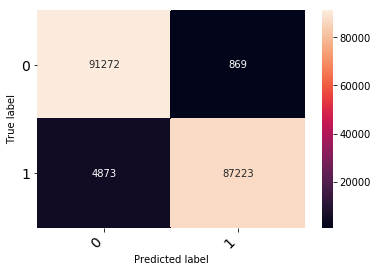

In [68]:
index_names=['0','1']
class_names=['0','1']
df_cm = pd.DataFrame(cm, index=index_names, columns=class_names)
hp =sns.heatmap(df_cm, annot=True, fmt="d")
hp.yaxis.set_ticklabels(hp.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
hp.xaxis.set_ticklabels(hp.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [69]:
print("f1-score    ",f1_score(label_Test,pred))
print("precision_score   ",precision_score(label_Test,pred))
#recall score
print("recall_score    ",recall_score(label_Test,pred))
#accuracy score
print("accuracy    ",accuracy_score(label_Test,pred))

f1-score     0.9681332830155173
precision_score    0.9901353130817782
recall_score     0.9470878214037526
accuracy     0.9688336219109083


In [80]:
Tr=Tr[:100000]
label_Tr=label_Train[:100000]
Te=Te[:50000]
label_Te=label_Test[:50000]

# Gradient Boosting Descision Tree

In [81]:
myList = [25,50,75,90,100]
maxdepth=[5,10,15,20,25]

# empty list that will hold cv scores
#cv_scores = []
optimal_c=0
m=0
maxd=0
mean=0
# perform 10-fold cross validation
for k in myList:
    for l in maxdepth:
        DT = GradientBoostingClassifier(n_estimators=k,max_depth=l)
        scores = cross_val_score(DT,Tr, label_Tr, cv=3, scoring='accuracy')
        m=scores.mean()
        if(mean<m):
            mean=m
            optimal_c=k
            maxd=l
        #cv_scores.append(scores.mean())
        print("\n cv score for no of estimators ={} and max_depth = {} is {}".format(k,l,m))
        

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

#optimal_c = myList[MSE.index(min(MSE))]
print('\nThe optimal no of estimators are {} and Max depth is{}.' .format(optimal_c,maxd))


 cv score for no of estimators =25 and max_depth = 5 is 0.816259967852365

 cv score for no of estimators =25 and max_depth = 10 is 0.8578499748857776

 cv score for no of estimators =25 and max_depth = 15 is 0.8610000246892938

 cv score for no of estimators =25 and max_depth = 20 is 0.8237700894608052

 cv score for no of estimators =25 and max_depth = 25 is 0.8075899540451529

 cv score for no of estimators =50 and max_depth = 5 is 0.8353399792678573

 cv score for no of estimators =50 and max_depth = 10 is 0.8739999626984538

 cv score for no of estimators =50 and max_depth = 15 is 0.8702900080963939

 cv score for no of estimators =50 and max_depth = 20 is 0.8279701242648613

 cv score for no of estimators =50 and max_depth = 25 is 0.8057400336452649

 cv score for no of estimators =75 and max_depth = 5 is 0.8452999696756335

 cv score for no of estimators =75 and max_depth = 10 is 0.880569956103578

 cv score for no of estimators =75 and max_depth = 15 is 0.8759400073008979

 cv

In [82]:
DT = GradientBoostingClassifier(n_estimators=optimal_c,max_depth=maxd)
DT.fit(Tr,label_Tr)
pred= DT.predict(Te)
acc = accuracy_score(label_Te, pred, normalize=True) * float(100)
print("\n****Test accuracy for no estimators ={} and max_depth {} is {}".format(optimal_c,maxd,acc))


****Test accuracy for no estimators =100 and max_depth 10 is 89.834


In [86]:
cm=confusion_matrix(label_Te,pred)
tn, fp, fn, tp = confusion_matrix(label_Te,pred).ravel()
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 23063 
 false positives are 1954 
 false negatives are 3129
 true positives are 21854 
 


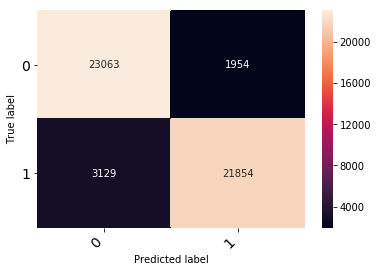

In [87]:
index_names=['0','1']
class_names=['0','1']
df_cm = pd.DataFrame(cm, index=index_names, columns=class_names)
hp =sns.heatmap(df_cm, annot=True, fmt="d")
hp.yaxis.set_ticklabels(hp.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
hp.xaxis.set_ticklabels(hp.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [88]:
print("f1-score    ",f1_score(label_Te,pred))
print("precision_score   ",precision_score(label_Te,pred))
#recall score
print("recall_score    ",recall_score(label_Te,pred))
#accuracy score
print("accuracy    ",accuracy_score(label_Te,pred))

f1-score     0.8958209505851489
precision_score    0.917926747311828
recall_score     0.874754833286635
accuracy     0.89834


# TF-iDF word 2 vec

In [35]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [38]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 429885/429885 [24:52<00:00, 255.41it/s]


In [39]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 184237/184237 [12:07<00:00, 253.24it/s]


In [40]:
Tra=np.array(tfidf_sent_vectors)
inds = np.where(np.isnan(Tra))
Tra[inds]=0
Tes=np.array(tfidf_sent_vectors1)
inds = np.where(np.isnan(Tes))
Tes[inds]=0

# k fold cross validation

In [42]:

myList = [10,15,20,25,30]
maxdepth=[5,10,15,20,25]

# empty list that will hold cv scores
#cv_scores = []
optimal_c=0
m=0
maxd=0
mean=0
# perform 10-fold cross validation
for k in myList:
    for l in maxdepth:
        DT = RandomForestClassifier(n_estimators=k,max_depth=l,n_jobs=-1)
        scores = cross_val_score(DT,Tra, label_Train, cv=5, scoring='accuracy')
        m=scores.mean()
        if(mean<m):
            mean=scores.mean()
            optimal_c=k
            maxd=l
        #cv_scores.append(scores.mean())
        print("\n cv score for no of estimators ={} and max_depth = {} is {}".format(k,l,m))
        

# changing to misclassification error
#MSE = [1 - x for x in cv_scores]

#optimal_c = myList[MSE.index(min(MSE))]
print('\nThe optimal no of estimators are {} and Max depth is{}.' .format(optimal_c,maxd))


 cv score for no of estimators =10 and max_depth = 5 is 0.7566721332449375

 cv score for no of estimators =10 and max_depth = 10 is 0.8146643869872175

 cv score for no of estimators =10 and max_depth = 15 is 0.9056445328401782

 cv score for no of estimators =10 and max_depth = 20 is 0.9402933342638148

 cv score for no of estimators =10 and max_depth = 25 is 0.9391092966723658

 cv score for no of estimators =15 and max_depth = 5 is 0.7610081766053712

 cv score for no of estimators =15 and max_depth = 10 is 0.8188864463751934

 cv score for no of estimators =15 and max_depth = 15 is 0.9111204159251892

 cv score for no of estimators =15 and max_depth = 20 is 0.9446619444735219

 cv score for no of estimators =15 and max_depth = 25 is 0.9508822126847878

 cv score for no of estimators =20 and max_depth = 5 is 0.7620782302243624

 cv score for no of estimators =20 and max_depth = 10 is 0.8213661793270293

 cv score for no of estimators =20 and max_depth = 15 is 0.9141561115181966

 

In [44]:
DT = RandomForestClassifier(n_estimators=optimal_c,max_depth=maxd,n_jobs=-1)
DT.fit(Tra,label_Train)
pred= DT.predict(Tes)
acc = accuracy_score(label_Test, pred, normalize=True) * float(100)
print("\n****Test accuracy for no estimators ={} and max_depth {} is {}".format(optimal_c,maxd,acc))


****Test accuracy for no estimators =30 and max_depth 25 is 96.98106243588421


# GridSearchCv

In [45]:
tuned_parameters = [{'n_estimators': [5,10,15,20,25,30],'max_depth':[5,10,15,20,25]}]
model = GridSearchCV(RandomForestClassifier(n_jobs=-1), tuned_parameters, scoring = 'f1', cv=3,n_jobs=-1)
model.fit(Tra,label_Train)

print(model.best_estimator_)
print(model.score(Tes, label_Test))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9682138862123578


# RandomizedSearchCV

In [47]:
tuned_parameters = {'n_estimators': [5,10,15,20,25,26,27,28,29,30,31,32,33,34,35],'max_depth':[5,10,15,20,25,30,35,40,45,50,55,60]}
model = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1), tuned_parameters, scoring = 'f1', cv=3)
model.fit(Tra,label_Train)

print(model.best_estimator_)
print(model.score(Tes, label_Test))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=27, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9690254957193536


In [48]:
cm=confusion_matrix(label_Test,pred)
tn, fp, fn, tp = confusion_matrix(label_Test,pred).ravel()
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 91102 
 false positives are 1039 
 false negatives are 4523
 true positives are 87573 
 


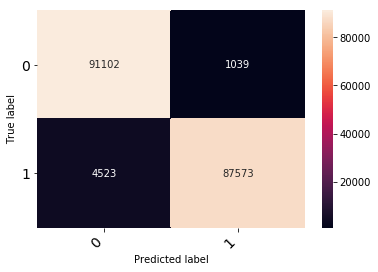

In [49]:
index_names=['0','1']
class_names=['0','1']
df_cm = pd.DataFrame(cm, index=index_names, columns=class_names)
hp =sns.heatmap(df_cm, annot=True, fmt="d")
hp.yaxis.set_ticklabels(hp.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
hp.xaxis.set_ticklabels(hp.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [50]:
print("f1-score    ",f1_score(label_Test,pred))
print("precision_score   ",precision_score(label_Test,pred))
#recall score
print("recall_score    ",recall_score(label_Test,pred))
#accuracy score
print("accuracy    ",accuracy_score(label_Test,pred))

f1-score     0.9692210638156584
precision_score    0.988274725770776
recall_score     0.9508882036136206
accuracy     0.9698106243588421


In [53]:
Tran=Tra[:100000]
label_Tr=label_Train[:100000]
Test=Tes[:50000]
label_Te=label_Test[:50000]

# Gradient Boosting Descision Tree

In [54]:
myList = [25,50,75,100,125]
maxdepth=[5,10,15,20,25]

# empty list that will hold cv scores
#cv_scores = []
optimal_c=0
m=0
maxd=0
mean=0
# perform 10-fold cross validation
for k in myList:
    for l in maxdepth:
        DT = GradientBoostingClassifier(n_estimators=k,max_depth=l)
        scores = cross_val_score(DT,Tran, label_Tr, cv=3, scoring='accuracy')
        m=scores.mean()
        if(mean<m):
            mean=scores.mean()
            optimal_c=k
            maxd=l
        #cv_scores.append(scores.mean())
        print("\n cv score for no of estimators ={} and max_depth = {} is {}".format(k,l,m))
        

# changing to misclassification error
#MSE = [1 - x for x in cv_scores]

#optimal_c = myList[MSE.index(min(MSE))]
print('\nThe optimal no of estimators are {} and Max depth is{}.' .format(optimal_c,maxd))


 cv score for no of estimators =25 and max_depth = 5 is 0.7920099884333767

 cv score for no of estimators =25 and max_depth = 10 is 0.8417699856731294

 cv score for no of estimators =25 and max_depth = 15 is 0.8461699762764615

 cv score for no of estimators =25 and max_depth = 20 is 0.8015799206396768

 cv score for no of estimators =25 and max_depth = 25 is 0.7833399476256244

 cv score for no of estimators =50 and max_depth = 5 is 0.812510012850265

 cv score for no of estimators =50 and max_depth = 10 is 0.8579199878860937

 cv score for no of estimators =50 and max_depth = 15 is 0.8579699892861617

 cv score for no of estimators =50 and max_depth = 20 is 0.811720038250141

 cv score for no of estimators =50 and max_depth = 25 is 0.7820898988236484

 cv score for no of estimators =75 and max_depth = 5 is 0.8220099920574491

 cv score for no of estimators =75 and max_depth = 10 is 0.8646099908915058

 cv score for no of estimators =75 and max_depth = 15 is 0.8610800014888937

 cv

In [56]:
DT = GradientBoostingClassifier(n_estimators=optimal_c,max_depth=maxd)
DT.fit(Tran,label_Tr)
pred= DT.predict(Test)
acc = accuracy_score(label_Te, pred, normalize=True) * float(100)
print("\n****Test accuracy for no estimators ={} and max_depth {} is {}".format(optimal_c,maxd,acc))


****Test accuracy for no estimators =125 and max_depth 10 is 88.482


In [58]:
cm=confusion_matrix(label_Te,pred)
tn, fp, fn, tp = confusion_matrix(label_Te,pred).ravel()
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 22648 
 false positives are 2369 
 false negatives are 3390
 true positives are 21593 
 


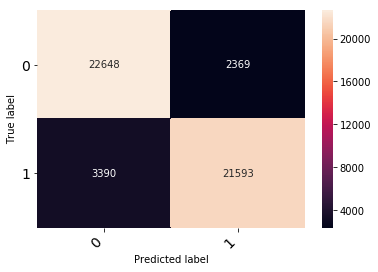

In [59]:
index_names=['0','1']
class_names=['0','1']
df_cm = pd.DataFrame(cm, index=index_names, columns=class_names)
hp =sns.heatmap(df_cm, annot=True, fmt="d")
hp.yaxis.set_ticklabels(hp.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
hp.xaxis.set_ticklabels(hp.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [60]:
print("f1-score    ",f1_score(label_Te,pred))
print("precision_score   ",precision_score(label_Te,pred))
#recall score
print("recall_score    ",recall_score(label_Te,pred))
#accuracy score
print("accuracy    ",accuracy_score(label_Te,pred))

f1-score     0.8823373173970784
precision_score    0.9011351306234872
recall_score     0.864307729255894
accuracy     0.88482


# Table to compare all the Featurizations Using Random Forests

|features    |  Bag of Words  | Tf-idf |avg Word2vec |tfidf word2vec
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|hyperparameter(estimators)| 30 | 30 | 30| 30 |
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|hyperparameter(max_depth)| 25 | 25 | 25| 25 |
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|Test accuracy|85.20655460086736|84.22955215293345|96.88336219109082|96.98106243588421|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|GridSearchCV(estimators)|30|30|30|30|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|GridSearchCV(max_depth)|25|25|25|25|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|GridSearchCV(score)|0.8519944749068687|0.8602918281671086|0.9679377621911971|0.9682138862123578|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|RandomizedSearchCV(estimators)|35|35|31|27|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|RandomizedSearchCV(max_depth)|55|35|55|50|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|RandomizedSearchCV(score)|0.9173282057341741|0.9301925983926571|0.9697241857241857|0.9690254957193536|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|true negitves|76220|74896|91272|91102|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|true positives|80762|80286|87223|87573|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|false positives|15921|17245| 869|1039|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|false negatives|11334|11810|4873|4523|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|f1-score|0.85562483115177| 0.8467781486813587|0.9681332830155173|0.9692210638156584|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|precision_score|0.8353278239194067|0.823184423414094|0.9901353130817782|0.988274725770776|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|recall_score|0.87693276580959|0.8717642460041696|0.9470878214037526|0.9508882036136206|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|
|accuracy_score|0.8520655460086736|0.8422955215293345|0.9688336219109083|0.9698106243588421|
|---------------|----------------------|-----------------------------------|-------------------|-----------------------|


# Table for Comparision Of Featurizations Using Gradien Boosted Descision Tree

|features    | avg Word2vec |tfidf word2vec |
|---------------|----------------------|-----------------------------------|
|hyperparameter(estimators)| 100| 125 |
|---------------|----------------------|-----------------------------------|
|hyperparameter(max_depth)| 10| 10 |
|---------------|----------------------|-----------------------------------|
|Test accuracy|89.834|88.482|
|---------------|----------------------|-----------------------------------|
|true negitves|23063|22648|
|---------------|----------------------|-----------------------------------|
|true positives|21854|21593|
|---------------|----------------------|-----------------------------------|
|false positives| 1954|2369|
|---------------|----------------------|-----------------------------------|
|false negatives|3129|3390|
|---------------|----------------------|-----------------------------------|
|f1-score|0.8958209505851489|0.8823373173970784|
|---------------|----------------------|-----------------------------------|
|precision_score|0.917926747311828|0.9011351306234872|
|---------------|----------------------|-----------------------------------|
|recall_score|0.874754833286635|0.864307729255894|
|---------------|----------------------|-----------------------------------|
|accuracy_score|0.89834|0.88482|
|---------------|----------------------|-----------------------------------|

# conclusion

1.Random Forests works Better than Gradient Boosted Descision Tree for All the Featurizations

2.in Random Forest Tf idf word 2 vec  Performs Slightly Better Than all the Featurizations

3.in GBDT avg Word2vec performs Better than Tfidf Word2Vec

4.Random Forests performs Better Than All the Previous Models

5.Tf idf word 2 vec has an accuracy 96.98106243588421 